### *CS452 Assignment 2 - Car Rollover Prediction*

***Instructor: Assistant Prof. Reyhan Aydoğan***

In [1]:
# Author: Uygar KAYA
# Department: Computer Science
# Degree: BSc.

In [2]:
# Importing required libraries for this assignment

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests as rq
import io
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.inspection import permutation_importance

from sklearn.naive_bayes import GaussianNB, CategoricalNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 150)
random.seed(42) # DO NOT CHANGE
np.random.seed(42) # DO NOT CHANGE

## *Part 1 - Data Loading and Cleaning*
***Getting FARS datasets through the API provided by NHTSA using requests library.***<br>

***Two types of datasets will be used in the project:<br>
"person" dataset provides the information of persons involved in a crash.<br>
"vindecode" dataset the information of vehicles involved in a crash thanks to decoded Vehicle Identification Number (VIN).***

In [3]:
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData"
case_years = np.arange(2014, 2020, dtype=int) # DO NOT CHANGE

In [4]:
def get_persons_data(year):
    response = rq.get(url = api, params = {'dataset':'person', 'caseYear':year, 'format':'csv'})

    if response.ok:
        csv_data = response.content
        persons = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
        return persons
    
    print("Failed to get the data")
    print(response.status)
    
    return None

def get_vehicles_data(year):
    response = rq.get(url = api, params = {'dataset':'vindecode', 'caseYear':year, 'format':'csv'})

    if response.ok:
        csv_data = response.content
        vehicles = pd.read_csv(io.StringIO(csv_data.decode('utf-8')))
        return vehicles
    
    print("Failed to get the data")
    print(response.status)
    
    return None

### ***Fecthing vehicles and persons datasets from 2014 to 2019.***

In [5]:
# Fecth the person and vindecode data with the help of the API and print the shape of these data

personDF = pd.DataFrame()
for year in case_years:
    personDF = personDF.append(get_persons_data(year), ignore_index = True)

vehicleDF = pd.DataFrame()
for year in case_years:
    vehicleDF = vehicleDF.append(get_vehicles_data(year), ignore_index = True)
    
print("Person DataFrame Shape:", personDF.shape)
print("Vehicle DataFrame Shape:", vehicleDF.shape)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_8588/4030804871.py:6: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  personDF = personDF.append(get_persons_data(year), ignore_index = True)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_8588/4030804871.py:6: DtypeWarning: Columns (17,32) have mixed types.Specify dtype option on import or set low_memory=False.
  personDF = personDF.append(get_persons_data(year), ignore_index = True)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_8588/4030804871.py:10: DtypeWarning: Columns (25,51,52,96) have mixed types.Specify dtype option on import or set low_memory=False.
  vehicleDF = vehicleDF.append(get_vehicles_data(year), ignore_index = True)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_8588/4030804871.py:10: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  vehicleDF = vehicleDF.append(get_vehicles_data(year), ignore_index = True)
C:\Users\ASUS\AppData\Lo

Person DataFrame Shape: (498002, 131)
Vehicle DataFrame Shape: (313877, 105)


In [6]:
# Showing the first 5 row for person DataFrame
personDF.head()

,caseyear,state,statename,st_case,ve_forms,veh_no,per_no,str_veh,str_vehname,county,countyname,day,month,monthname,hour,hourname,minute,minutename,road_fnc,road_fncname,harm_ev,harm_evname,man_coll,man_collname,sch_bus,sch_busname,make,makename,mak_mod,body_typ,body_typname,mod_year,mod_yearname,tow_veh,tow_vehname,spec_use,spec_usename,emer_use,emer_usename,rollover,rollovername,impact1,impact1name,fire_exp,fire_expname,age,agename,sex,sexname,per_typ,per_typname,inj_sev,inj_sevname,seat_pos,seat_posname,rest_use,rest_usename,rest_mis,rest_misname,air_bag,air_bagname,ejection,ejectionname,ej_path,ej_pathname,extricat,extricatname,drinking,drinkingname,alc_det,alc_detname,alc_status,alc_statusname,atst_typ,atst_typname,alc_res,alc_resname,drugs,drugsname,drug_det,drug_detname,dstatus,dstatusname,drugtst1,drugtst1name,drugres1,drugres1name,drugtst2,drugtst2name,drugres2,drugres2name,drugtst3,drugtst3name,drugres3,drugres3name,hospital,hospitalname,doa,doaname,death_da,death_daname,death_mo,death_moname,death_yr,death_yrname,death_hr,death_hrname,death_mn,death_mnname,death_tm,lag_hrs,lag_mins,p_sf1,p_sf1name,p_sf2,p_sf2name,p_sf3,p_sf3name,cert_no,work_inj,work_injname,hispanic,hispanicname,race,racename,location,locationname,func_sys,func_sysname,rur_urb,rur_urbname
0,2014,1,Alabama,10001,1,1,1,0,Occupant of a Motor Vehicle,71,JACKSON (71),1,1,January,1,1:00am-1:59am,15,15,5.0,Rural-Minor Collector,17,Boulder,0,Not a Collision with Motor Vehicle In-Transport,0,No,49.0,Toyota,49032.0,4.0,"4-door sedan, hardtop",2011.0,2011,0.0,No Trailing Units,0.0,No Special Use,0.0,Not Applicable,1.0,"Rollover, Tripped by Object/Vehicle",11.0,11 Clock Point,0.0,No or Not Reported,24,24 Years,1,Male,1,Driver of a Motor Vehicle In-Transport,4,Fatal Injury (K),11,"Front Seat, Left Side",3,Shoulder and Lap Belt Used,0,No,8,Deployed- Combination,0,Not Ejected,0,Not Ejected/Not Applicable,1,Extricated,1,Yes (Alcohol Involved),5,Observed,2,Test Given,1,Blood,26,0.26 % BAC,9,Unknown,8,Not Reported,2,Test Given,1.0,Blood,998.0,"Tested For Drugs, Drugs Found, Type unknown/Po...",0.0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,0,Not Transported,7,Died at Scene,1,1,1,January,2014,2014,1,1:00-1:59,15,15,115,0,0,0,None,0,None,0,None,************,0,No,7,Non-Hispanic,1.0,White,0,0,NaN,NaN,NaN,NaN
1,2014,1,Alabama,10001,1,1,2,0,Occupant of a Motor Vehicle,71,JACKSON (71),1,1,January,1,1:00am-1:59am,15,15,5.0,Rural-Minor Collector,17,Boulder,0,Not a Collision with Motor Vehicle In-Transport,0,No,49.0,Toyota,49032.0,4.0,"4-door sedan, hardtop",2011.0,2011,0.0,No Trailing Units,0.0,No Special Use,0.0,Not Applicable,1.0,"Rollover, Tripped by Object/Vehicle",11.0,11 Clock Point,0.0,No or Not Reported,30,30 Years,2,Female,2,Passenger of a Motor Vehicle In-Transport,2,Suspected Minor Injury(B),13,"Front Seat, Right Side",3,Shoulder and Lap Belt Used,0,No,8,Deployed- Combination,0,Not Ejected,0,Not Ejected/Not Applicable,0,Not Extricated or Not Applicable,8,Not Reported,9,Not Reported,0,Test Not Given,0,Test Not Given,96,Test Not Given,8,Not Reported,8,Not Reported,0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,0.0,Test Not Given,1,EMS Air,0,Not Applicable,88,Not Applicable (Non-Fatal),88,Not Applicable (Non-Fatal),8888,Not Applicable (Non-fatal),88,Not Applicable (Non-fatal),88,Not Applicable (Non-fatal),8888,999,99,0,None,0,None,0,None,************,8,Not Applicable (not a fatality),0,Not A Fatality (not Applicable),0.0,Not a Fatality (not Applicable),0,0,NaN,NaN,NaN,NaN
2,2014,1,Alabama,10002,1,1,1,0,Occupant of a Motor Vehicle,59,FRANKLIN (59),1,1,January,13,1:00pm-1:59pm,30,30,6.0,Rural-Local Road or Street,42,Tree (Standing Only),0,Not a Collision with Motor Vehicle In-Transport,0,No,7.0,Dodge,7482.0,31.0,"Standard pickup (GVWR 4,500 to 10,00 lbs.)(Jee...",1997.0,1997,0.0,No Trailing Units,0.0,No Special Use,0.0,Not Applicable,0.0,No Rollover,12.0,12 Clock Point,0.0,No o

In [7]:
# Showing the first 5 row for vehicle DataFrame
vehicleDF.head()

,caseyear,state,statename,st_case,veh_no,ncicmake,vinyear,vehtype,vehtype_t,vinmake_t,vinmodel_t,vintrim_t,vintrim1_t,vintrim2_t,vintrim3_t,vintrim4_t,bodystyl,bodystyl_t,doors,wheels,drivwhls,mfg,mfg_t,displci,displcc,cylndrs,cycles,fuel,fuel_t,fuelinj,fuelinj_t,carbtype,carbtype_t,carbbrls,gvwrange,gvwrange_t,whlbsh,whlblg,tiredesc_f,psi_f,tiresz_f,tiresz_f_t,tiredesc_r,psi_r,rearsize,rearsize_t,tonrating,shipweight,msrp,drivetyp,drivetyp_t,salectry,salectry_t,abs,abs_t,security,security_t,drl,drl_t,rstrnt,rstrnt_t,tkcab,tkcab_t,tkaxlef,tkaxlef_t,tkaxler,tkaxler_t,tkbrak,tkbrak_t,engmfg,engmfg_t,engmodel,tkduty,tkduty_t,tkbedl,tkbedl_t,segmnt,segmnt_t,plant,plntctry_t,plntcity,plntctry,plntstat,plntstat_t,origin,origin_t,dispclmt,blocktype,enghead,enghead_t,vlvclndr,vlvtotal,engvincd,incomplt,battyp,battyp_t,batkwrtg,batvolt,supchrgr,supchrgr_t,turbo,turbo_t,engvvt,mcyusage,mcyusage_t
0,2014,1,Alabama,10001,1,TOYT,2011.0,P,Passenger Car,TOYOTA,COROLLA,BASE,S,LE,NaN,NaN,SD,Sedan,4.0,4.0,2.0,C175,TOYOTA,110.0,0.0,4.0,NaN,G,Gas,NaN,NaN,F,Fuel Injection,NaN,NaN,NaN,102.4,102.4,NaN,0.0,29,15R195,NaN,0.0,29.0,15R195,NaN,2734.0,15600.0,FWD,Front Wheel Drive,NaN,NaN,2,All Wheel Std,F,Immobilizer and keyless entry,S,Standard,7,Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,Non Luxury Traditional Compact,C,Canada,CAMBRIDGE,CAN,ON,ONTARIO,B,Import Built in North America,1.8,In-Line,DOHC,Double Overhead Camshaft,4.0,16.0,U,N,NaN,NaN,NaN,NaN,N,No,N,No,NaN,NaN,NaN
1,2014,1,Alabama,10002,1,DODG,1997.0,T,Truck,DODGE,RAM 2500,NaN,NaN,NaN,NaN,NaN,PK,Pickup,2.0,4.0,2.0,C127,DAIMLER-CHRYSLER,360.0,0.0,8.0,NaN,G,Gas,U,Unknown,F,Fuel Injection,NaN,2.0,"6,001 - 10,000#",138.7,154.7,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,C,4787.0,20775.0,RWD,Rear Wheel Drive,NaN,NaN,4,Other Std,U,Unknown,N,Not Available,M,Driver Front Air Bag/Passenger Active Belts,EXT,Extended Cab,N,Standard Axle,S,Single,HYD,HYDRAULIC,050,CHRYSLER,5.9L,ME,Medium Duty,R,Regular,7,Non Luxury Full Size 3qtr to 1 Ton Pickup,M,Mexico,LAGO ALBERTO,MEX,NaN,NaN,D,Domestic,5.9,V-type,OHV,Overhead Valve,2.0,16.0,Z,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,Alabama,10003,1,CHEV,2004.0,P,Passenger Car,CHEVROLET,MALIBU,LT,NaN,NaN,NaN,NaN,SD,Sedan,4.0,0.0,0.0,C137,GENERAL MOTORS,214.0,0.0,6.0,NaN,G,Gas,U,Unknown,F,Fuel Injection,NaN,NaN,NaN,106.3,106.3,NaN,0.0,38,16R215,NaN,0.0,NaN,NaN,NaN,3315.0,23495.0,FWD,Front Wheel Drive,NaN,NaN,2,All Wheel Std,P,Pass Key,S,Standard,K,Dual Air Bags Front and Sides/Active Belts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,Non Luxury Traditional Mid Size,F,United States,FAIRFAX,USA,KS,KANSAS,D,Domestic,3.5,V-type,NaN,NaN,0.0,0.0,8,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,Alabama,10003,2,TOYT,1997.0,P,Passenger Car,TOYOTA,CAMRY,CE,LE,XLE,NaN,NaN,SD,Sedan,4.0,0.0,0.0,C175,TOYOTA,183.0,0.0,6.0,NaN,G,Gas,U,Unknown,F,Fuel Injection,NaN,NaN,NaN,105.1,105.1,NaN,0.0,30,15R205,NaN,0.0,NaN,NaN,NaN,3086.0,19248.0,FWD,Front Wheel Drive,NaN,NaN,5,All Wheel Opt,U,Unknown,N,Not Available,E,Dual Front Air Bag/Active Belts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,Non Luxury Traditional Mid Size,U,United States,GEORGETOWN,USA,KY,KENTUCKY,B,Import Built in North America,3.0,V-type,NaN,NaN,4.0,24.0,F,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,Alabama,10004,1,TOYT,1999.0,T,Truck,TOYOTA,TACOMA,NaN,NaN,NaN,NaN,NaN,PK,Pickup,2.0,4.0,2.0,C175,TOYOTA,149.0,0.0,4.0,NaN,G,Gas,U,Unknown,F,Fuel Injection,NaN,1.0,"0 - 6,000#",103.3,103.3,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,B,2567.0,12698.0,RWD,Rear Wheel Drive,NaN,NaN,5,All Wheel Opt,U,Unknown,N,Not Available,Z,Du Ar Bgs Frnt/Act Blts/Pass Deactivate/cutoff,CON,Conventional,U,Unknown,U,Unknown,U,Unknown,NaN,NaN,NaN,U,Unknown,R,Regular,T,Non Luxury Mid Size Pickup,Z,United States,FREMONT,USA,CA,CALIFORNIA,B,Import Built in North America,2.4,In-Line,DOHC,Double Overhead Camshaft,0.0,0.0,L,N,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [8]:
# Droping the person types other than the driver
personDF.drop(personDF[personDF['per_typ'] != 1].index, inplace = True)

### ***Determining the useless columns to drop from the dataframes.***

***Hint 1: An encoded and a decoded (actual-valued) column exist for most of the features. Drop the encoded columns.***<br>
***Hint 2: Some features have mostly null values or a single value.*** <br>
***Hint 3: Some features provides information that can be obtained after the accident.*** <br>
***Refering to [FARS User’s Manual](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813023)***

In [9]:
# Be aware that this is a mutable method
def drop_useless_columns(vehicles, persons):

    vec_cols_to_drop = ["state", "ncicmake", "vehtype", "bodystyl", "mfg", "displcc", "fuel", "fuelinj", "carbtype", "gvwrange", "tiresz_f", "rearsize", "drivetyp", "salectry", "abs", "security", "drl", "rstrnt", "tkcab", "tkaxlef", "tkaxler", "tkbrak", "engmfg", "tkduty", "tkbedl", "segmnt", "plntctry", "plntstat", "origin", "enghead", "battyp", "supchrgr", "mcyusage", "turbo"] # fullfill the list with some column names of vehicles df
    per_cols_to_drop = ["state", "str_veh", "county", "hour", "minute", "road_fnc", "harm_ev", "man_coll", "sch_bus", "make", "body_typ","mak_mod", "mod_year", "tow_veh", "spec_use", "emer_use", "rollover", "impact1", "fire_exp", "age", "sex", "per_typ", "inj_sev", "seat_pos", "rest_use", "rest_mis", "air_bag", "ejection", "ej_path", "extricat", "drinking", "alc_det", "alc_status", "atst_typ", "alc_res", "drugs", "drug_det", "dstatus", "drugtst1", "drugres1", "drugtst2", "drugres2", "drugtst3", "drugres3", "hospital", "doa", "death_da", "death_mo", "death_yr", "death_hr", "death_mn", "p_sf1", "p_sf2", "p_sf3", "work_inj", "hispanic", "race", "location", "func_sys", "rur_urb"] # fullfill the list with some column names of persons df

    vehicles.drop(vec_cols_to_drop, axis=1, inplace=True)
    persons.drop(per_cols_to_drop, axis=1, inplace=True)

In [10]:
# Hint 1 -> Dropping the encoded columns

print("Vehicle Shape Before Drop:", vehicleDF.shape)
print("Person Shape Before Drop:", personDF.shape)

drop_useless_columns(vehicleDF, personDF)
print()

print("Vehicle Shape After Drop:", vehicleDF.shape)
print("Person Shape After Drop:", personDF.shape)

Vehicle Shape Before Drop: (313877, 105)
Person Shape Before Drop: (304126, 131)

Vehicle Shape After Drop: (313877, 71)
Person Shape After Drop: (304126, 71)


In [11]:
# Adding columns that is more than 90% null data to the list
# Getting the length of null data columns added to the list

vehicle_columns_most_null = []
person_columns_most_null = []

for key, value in vehicleDF.isnull().mean().iteritems():
    if value > 0.9:
        vehicle_columns_most_null.append(key)

for key, value in personDF.isnull().mean().iteritems():
    if value > 0.9:
        person_columns_most_null.append(key)

print("Vehicle Columns Null:", vehicle_columns_most_null, "- Vehicle Columns Null Length:", len(vehicle_columns_most_null))
print("Person Columns Null:", person_columns_most_null, "- Person Columns Null Length:", len(person_columns_most_null))

Vehicle Columns Null: ['vintrim2_t', 'vintrim3_t', 'vintrim4_t', 'cycles', 'carbbrls', 'tiredesc_f', 'tiredesc_r', 'salectry_t', 'batkwrtg', 'batvolt', 'mcyusage_t'] - Vehicle Columns Null Length: 11
Person Columns Null: [] - Person Columns Null Length: 0


In [12]:
# Hint 2 -> Dropping the null values
droppedVehicle = vehicleDF.drop(vehicle_columns_most_null, axis=1)
droppedPerson = personDF.drop(person_columns_most_null, axis=1)

print("Vehicle Shape After Drop:", droppedVehicle.shape)
print("Person Shape After Drop:", droppedPerson.shape)

Vehicle Shape After Drop: (313877, 60)
Person Shape After Drop: (304126, 71)


In [13]:
# Hint 2 -> Dropping the single values
droppedVehicle.drop(droppedVehicle.columns[droppedVehicle.nunique() <= 1], axis=1, inplace=True)
droppedPerson.drop(droppedPerson.columns[droppedPerson.nunique() <= 1], axis=1, inplace=True)

print("Vehicle Shape After Drop:", droppedVehicle.shape)
print("Person Shape After Drop:", droppedPerson.shape)

Vehicle Shape After Drop: (313877, 58)
Person Shape After Drop: (304126, 65)


In [14]:
# Hint 3 -> Some features provides information that can be obtained after the accident
person_columns_drop = ["ve_forms", "day", "month", "monthname", "hourname", "minutename", "road_fncname", "harm_evname", "man_collname", "sch_busname", "makename", "body_typname", "mod_yearname", "tow_vehname", "spec_usename", "emer_usename", "impact1name", "fire_expname", "inj_sevname", "seat_posname", "rest_usename", "rest_misname", "air_bagname", "ejectionname", "ej_pathname", "extricatname", "drinkingname", "alc_detname", "alc_statusname", "atst_typname", "alc_resname", "drugsname", "drug_detname", "dstatusname", "drugtst1name", "drugres1name", "drugtst2name", "drugres2name", "drugtst3name", "drugres3name", "hospitalname", "doaname", "death_daname", "death_moname", "death_yrname", "death_hrname", "death_mnname", "death_tm", "lag_hrs", "lag_mins", "work_injname", "hispanicname", "racename", "locationname", "func_sysname", "rur_urbname"]
droppedPerson.drop(person_columns_drop, axis=1, inplace=True)

print("Vehicle Shape After Drop:", droppedVehicle.shape)
print("Person Shape After Drop:", droppedPerson.shape)

Vehicle Shape After Drop: (313877, 58)
Person Shape After Drop: (304126, 9)


In [15]:
# Hint 1 & Hint 2 -> Merging Vehicle & Person DataFrames by inner join according to "caseyear", "st_case", "veh_no", "statename" key columns

def merge_vehicles_and_persons(vehicles, persons) -> pd.DataFrame:
    accidents = vehicles.merge(persons, how="inner", on=["caseyear", "st_case", "veh_no", "statename"])
    return accidents

In [16]:
# To obtain the single DataFrame which is name 'data'
data = merge_vehicles_and_persons(droppedVehicle, droppedPerson)

### ***Obtaining a single dataframe named 'data' by merging accidents dataframes of all available years. There might be some columns which do not present in all years.*** <br>

In [17]:
# Convert single DataFrame to csv file
data.to_csv("data.csv", encoding='utf-8', index=False)

In [18]:
# Read the saved final data file as a DataFrame.
# Remark: final dataset should comprise approximately 60 columns.
data = pd.read_csv("data.csv", na_values = ["Unknown", "UNKNOWN", "U", "None", "Other", "Not available", "Not applicable", "NOT APPLICABLE", "Not Reported", "Reported as Unknown"])

### ***Part 2 - Exploratory Data Analysis (EDA)***

***In this part, exploring categorical & numerical features and report some prominent characteristics of data.<br>
Try to get insights from the data for the feature engineering part.***<br>

***Detecting missing values, e.g. 0, NaN, 999, -1, representative words (unknown, unavailable, etc.), ...***<br>
***Dropping duplicate and empty rows/columns***<br>
***Histograms, scatter and bar plots***<br>
***Value counts of categorical features***<br>
***Statistical tables***

In [19]:
# Knowledge of data types and whether they are null or not
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304126 entries, 0 to 304125
Data columns (total 63 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   caseyear      304126 non-null  int64  
 1   statename     304126 non-null  object 
 2   st_case       304126 non-null  int64  
 3   veh_no        304126 non-null  int64  
 4   vinyear       291256 non-null  float64
 5   vehtype_t     291256 non-null  object 
 6   vinmake_t     291256 non-null  object 
 7   vinmodel_t    291235 non-null  object 
 8   vintrim_t     227574 non-null  object 
 9   vintrim1_t    45607 non-null   object 
 10  bodystyl_t    291256 non-null  object 
 11  doors         291256 non-null  float64
 12  wheels        291256 non-null  float64
 13  drivwhls      291256 non-null  float64
 14  mfg_t         283811 non-null  object 
 15  displci       291256 non-null  float64
 16  cylndrs       290818 non-null  object 
 17  fuel_t        260860 non-null  object 
 18  fuel

In [20]:
# Obtaining columns from categorical and numerical data types
toGetCategoricNumeric = data.columns.to_series().groupby(data.dtypes).groups
print(toGetCategoricNumeric)

{int64: ['caseyear', 'st_case', 'veh_no', 'per_no'], float64: ['vinyear', 'doors', 'wheels', 'drivwhls', 'displci', 'whlbsh', 'whlblg', 'shipweight', 'msrp', 'dispclmt', 'vlvclndr', 'vlvtotal'], object: ['statename', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'vintrim_t', 'vintrim1_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'engmodel', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plant', 'plntctry_t', 'plntcity', 'plntstat_t', 'origin_t', 'blocktype', 'enghead_t', 'engvincd', 'incomplt', 'battyp_t', 'supchrgr_t', 'turbo_t', 'engvvt', 'countyname', 'rollovername', 'agename', 'sexname']}


In [21]:
# Do not include record identifier columns (e.g. st_case, veh_no, etc.) into the following lists!

categorical = ['statename', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'vintrim_t', 'vintrim1_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'engmodel', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plant', 'plntctry_t', 'plntcity', 'plntstat_t', 'origin_t', 'blocktype', 'enghead_t', 'engvincd', 'incomplt', 'battyp_t', 'supchrgr_t', 'turbo_t', 'engvvt', 'countyname', 'agename', 'sexname'] # names of columns having categorical values
numeric = ['per_no', 'vinyear', 'doors', 'wheels', 'drivwhls', 'displci', 'whlbsh', 'whlblg', 'shipweight', 'msrp', 'dispclmt', 'vlvclndr', 'vlvtotal'] # names of columns having numerical values
target_name = 'rollovername' # set the column name of target variable (it is named 'rollovername' in FARS datasets) 

features = categorical + numeric

In [22]:
# Check the missing values 
data.isnull().sum().sort_values(ascending=False)

battyp_t        272726
vintrim1_t      258519
tkbedl_t        235821
fuelinj_t       227385
tonrating       225271
                 ...  
per_no               0
countyname           0
rollovername         0
st_case              0
caseyear             0
Length: 63, dtype: int64

In [23]:
# Checking the columns with missing values

print("\033[1m" + 'CATEGORICAL' + "\033[0m")
print(data[categorical].isnull().sum().sort_values(ascending=False))

print("\033[1m" + 'NUMERICAL' + "\033[0m")
print(data[numeric].isnull().sum().sort_values(ascending=False))

CATEGORICAL
battyp_t      272726
vintrim1_t    258519
tkbedl_t      235821
fuelinj_t     227385
tonrating     225271
rearsize_t    224898
tkaxlef_t     220248
engvvt        217889
supchrgr_t    213382
engmodel      210553
tkduty_t      210106
turbo_t       205810
tkaxler_t     204002
tkbrak_t      194239
engmfg_t      177610
tkcab_t       154425
gvwrange_t    153730
security_t    146548
enghead_t     124771
tiresz_f_t    122930
plntstat_t     94175
drl_t          81201
abs_t          76983
vintrim_t      76552
blocktype      67791
rstrnt_t       67671
carbtype_t     67362
engvincd       43659
drivetyp_t     43424
fuel_t         43266
segmnt_t       43134
plant          28931
plntcity       20651
mfg_t          20315
plntctry_t     15782
origin_t       13591
cylndrs        13308
vinmodel_t     12891
incomplt       12870
vehtype_t      12870
vinmake_t      12870
bodystyl_t     12870
agename         6586
sexname         6168
countyname         0
statename          0
dtype: int64
NUMERICAL

In [24]:
# Dropping the duplicate rows if exists
print("data' DataFrame Shape before duplicates: ", data.shape)
data.drop_duplicates(inplace=True)
print("data' DataFrame Shape after duplicates: ", data.shape)

data' DataFrame Shape before duplicates:  (304126, 63)
data' DataFrame Shape after duplicates:  (304126, 63)


In [25]:
# Dropping the most empty rows/columns

data_columns_most_null = []
for key, value in data.isnull().mean().iteritems():
    if value > 0.8:
        data_columns_most_null.append(key)
print("Data DataFrame Columns Null:", data_columns_most_null, "- Data DataFrame Columns Null Lenght:", len(data_columns_most_null))

Data DataFrame Columns Null: ['vintrim1_t', 'battyp_t'] - Data DataFrame Columns Null Lenght: 2


In [26]:
# Dropping the null columns
data.drop(data_columns_most_null, axis=1, inplace=True)
print("Data DataFrame Shape After Drop:", data.shape)

Data DataFrame Shape After Drop: (304126, 61)


In [27]:
# Rearranging the categorical list

categorical = ['statename', 'vehtype_t', 'vinmake_t', 'vinmodel_t', 'vintrim_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'engmodel', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plant', 'plntctry_t', 'plntcity', 'plntstat_t', 'origin_t', 'blocktype', 'enghead_t', 'engvincd', 'incomplt', 'supchrgr_t', 'turbo_t', 'engvvt', 'countyname', 'agename', 'sexname'] # names of columns having categorical values
numeric = ['per_no', 'vinyear', 'doors', 'wheels', 'drivwhls', 'displci', 'whlbsh', 'whlblg', 'shipweight', 'msrp', 'dispclmt', 'vlvclndr', 'vlvtotal'] # names of columns having numerical values
target_name = 'rollovername' # set the column name of target variable (it is named 'rollovername' in FARS datasets)

features = categorical + numeric

In [28]:
# Replace numeric' 0 values to NaN values
for columns in ["doors", "wheels", "drivwhls", "displci", "whlbsh", "whlblg", "shipweight", "msrp", "dispclmt"]:
    data[columns].replace(0, np.nan, inplace=True)

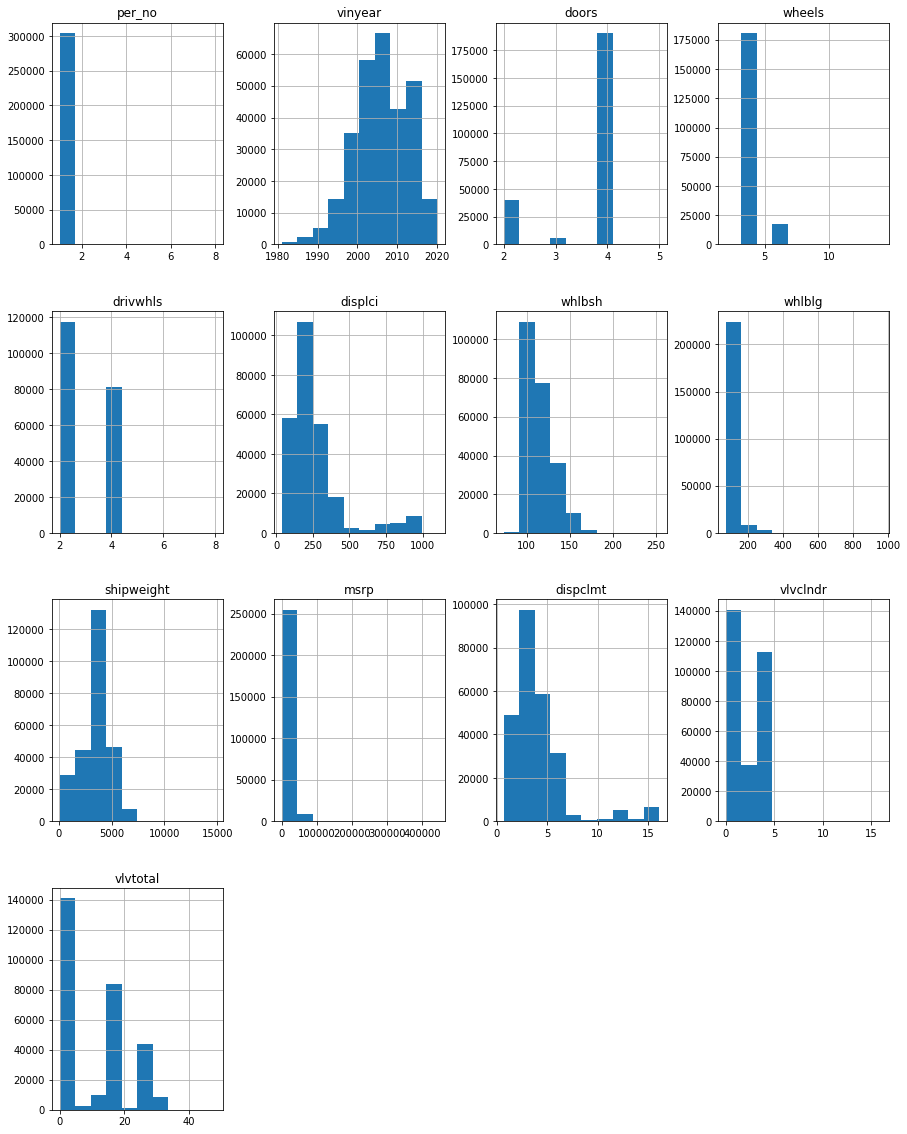

In [29]:
# Drawing a histogram for each numeric feature
data[numeric].hist(figsize=(15,20))

# Clear the text "residue"
plt.show()

In [30]:
# Value counts of categorical features
for categoric in data.dtypes[data.dtypes == 'object'].index:
    print("\033[1m" + categoric.upper() + "\033[0m")
    print(data[categoric].value_counts().to_dict())
    print()

STATENAME
{'Texas': 30626, 'California': 29936, 'Florida': 26104, 'Georgia': 12434, 'North Carolina': 11687, 'Pennsylvania': 9993, 'Ohio': 9561, 'Tennessee': 8689, 'Illinois': 8686, 'Michigan': 8605, 'New York': 8211, 'South Carolina': 8105, 'Arizona': 7677, 'Alabama': 7509, 'Missouri': 7436, 'Indiana': 7218, 'Virginia': 6458, 'Kentucky': 6296, 'Louisiana': 6181, 'Oklahoma': 5509, 'Mississippi': 5211, 'Colorado': 5049, 'New Jersey': 4771, 'Wisconsin': 4707, 'Washington': 4508, 'Maryland': 4426, 'Arkansas': 4355, 'Oregon': 3649, 'Minnesota': 3270, 'Kansas': 3270, 'New Mexico': 2972, 'Massachusetts': 2810, 'Iowa': 2778, 'Nevada': 2692, 'Puerto Rico': 2306, 'Utah': 2297, 'Connecticut': 2283, 'West Virginia': 2219, 'Nebraska': 1955, 'Idaho': 1784, 'Montana': 1359, 'Maine': 1185, 'Delaware': 1059, 'Wyoming': 995, 'South Dakota': 923, 'New Hampshire': 920, 'North Dakota': 897, 'Hawaii': 851, 'Alaska': 593, 'Vermont': 453, 'Rhode Island': 448, 'District of Columbia': 210}

VEHTYPE_T
{'Truck':

{'Front Wheel Drive': 112504, 'Rear Wheel Drive': 82670, 'Rear Wheel Drive w/4x4': 44840, 'All Wheel Drive': 18459, 'Front Wheel Drive w/4x4': 2224, 'FRONT WHEEL DRIVE': 5}

ABS_T
{'All Wheel Std': 180025, 'All Wheel Opt': 29206, 'Rear Wheel Std': 6634, 'Other Std': 5777, 'Other Opt': 5193, 'Rear Wheel Opt': 296, 'ALL WHEEL STD': 12}

SECURITY_T
{'Pass Key': 40236, 'Immobilizer / keyless entry / and alarm': 32481, 'Immobilizer and keyless entry': 21727, 'Sentry key / keyless entry / and alarm': 18764, 'Sentry key and keyless entry': 11462, 'Passive engine immobilizer': 11148, 'Active keyless entry': 6597, 'Keyless entry and alarm': 5306, 'Passive sentry key': 3494, 'Immobilizer': 3066, 'Sentry key and alarm': 2263, 'Immobilizer and alarm': 940, 'Engine immobilizer and sentry key': 51, 'Active alarm system': 31, 'IMMOBILIZER, KEYLESS ENTRY, AND ALARM': 12}

DRL_T
{'Standard': 100515, 'Not Available': 77717, 'Optional': 44654, 'Available': 34, 'STANDARD': 5}

RSTRNT_T
{'Dual Front Air Ba

{'22 Years': 7522, '21 Years': 7472, '23 Years': 7403, '24 Years': 7369, '25 Years': 7282, '26 Years': 6954, '27 Years': 6898, '28 Years': 6603, '20 Years': 6555, '19 Years': 6466, '29 Years': 6427, '30 Years': 6080, '31 Years': 5887, '18 Years': 5764, '32 Years': 5672, '33 Years': 5580, '34 Years': 5410, '35 Years': 5274, '36 Years': 5165, '37 Years': 5007, '55 Years': 4926, '38 Years': 4920, '51 Years': 4885, '54 Years': 4818, '52 Years': 4795, '50 Years': 4763, '53 Years': 4750, '56 Years': 4733, '48 Years': 4727, '39 Years': 4681, '49 Years': 4677, '46 Years': 4676, '40 Years': 4675, '42 Years': 4632, '57 Years': 4624, '47 Years': 4609, '45 Years': 4591, '44 Years': 4577, '41 Years': 4575, '58 Years': 4544, '43 Years': 4483, '59 Years': 4237, '60 Years': 4119, '17 Years': 3917, '61 Years': 3862, '62 Years': 3757, '63 Years': 3494, '64 Years': 3275, '65 Years': 3036, '66 Years': 2943, '67 Years': 2766, '68 Years': 2686, '69 Years': 2604, '16 Years': 2311, '70 Years': 2303, '71 Years

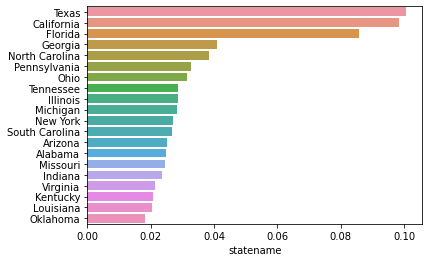

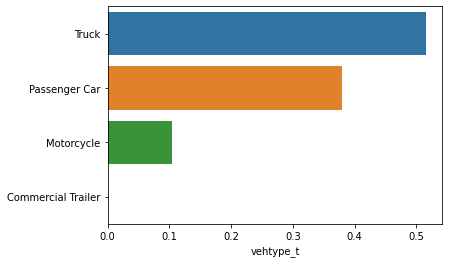

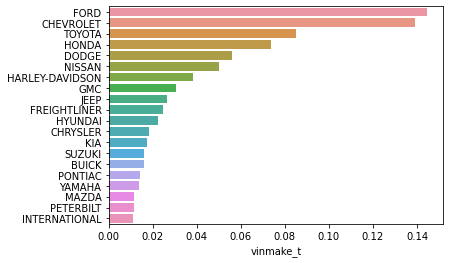

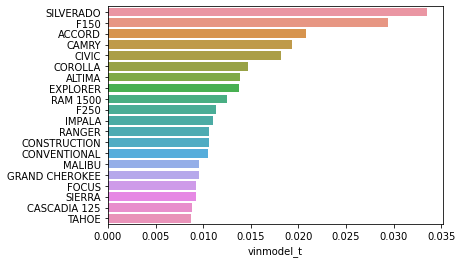

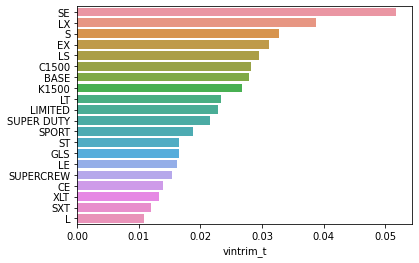

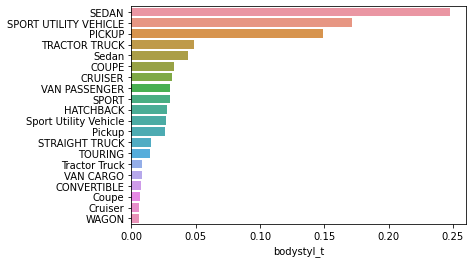

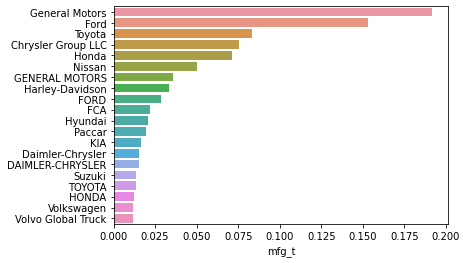

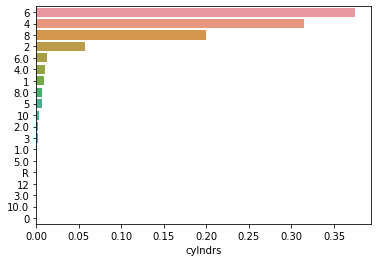

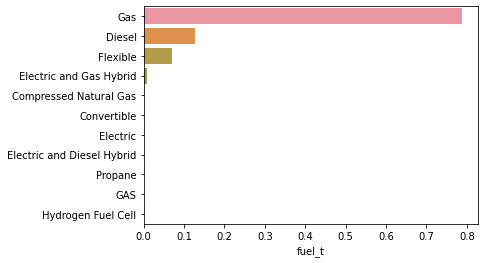

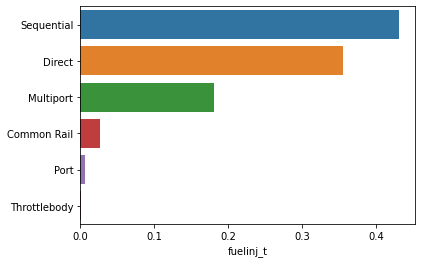

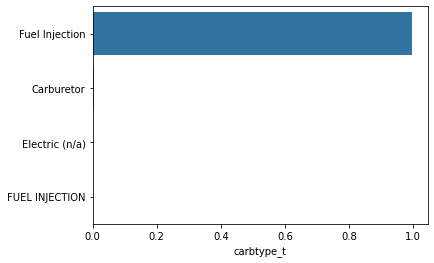

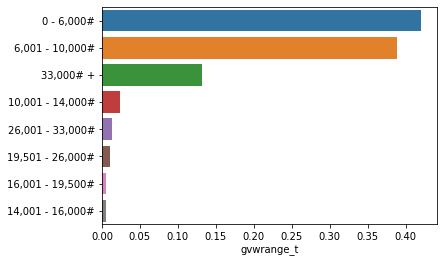

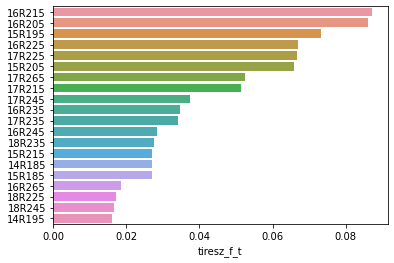

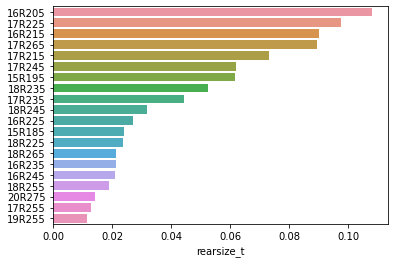

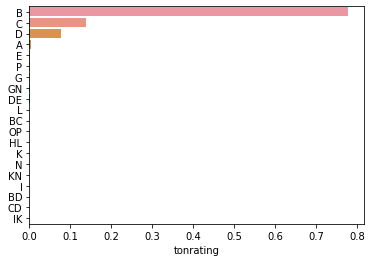

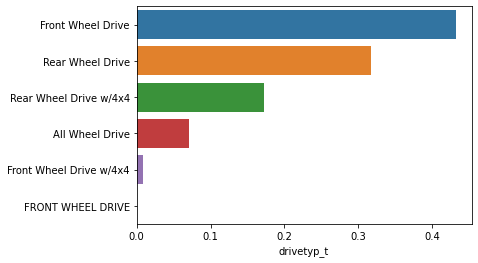

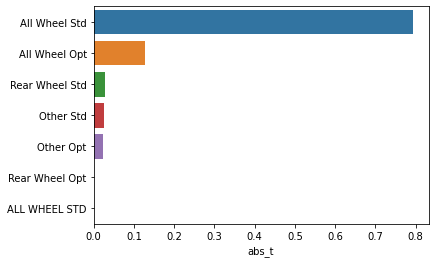

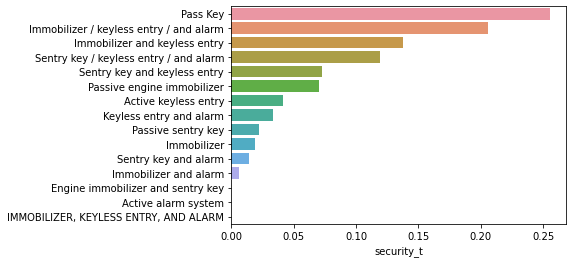

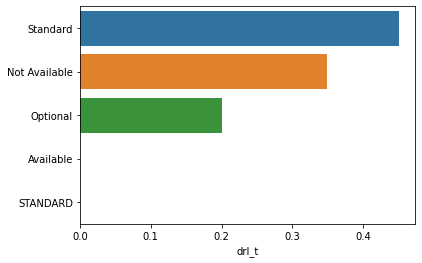

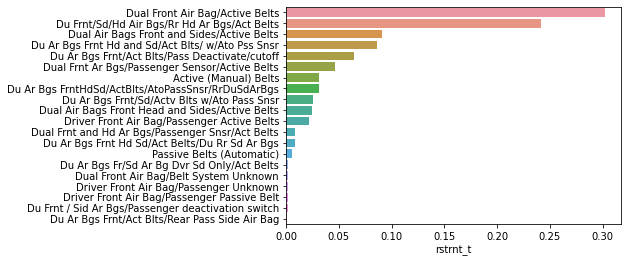

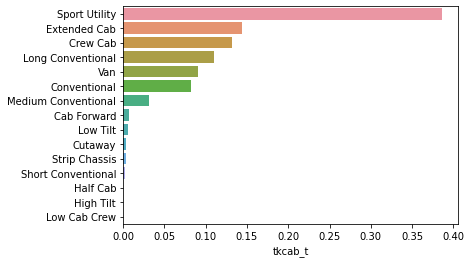

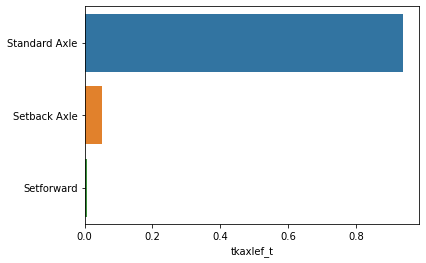

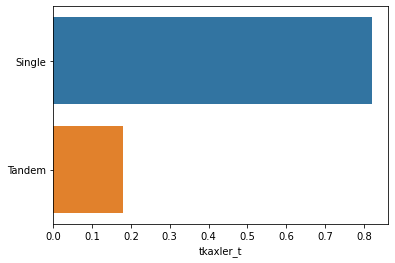

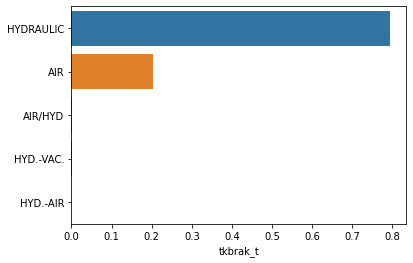

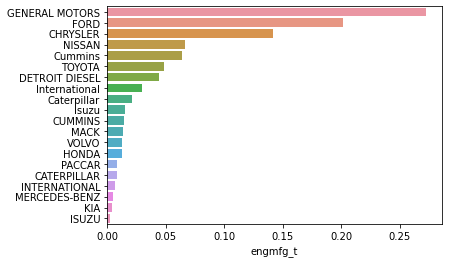

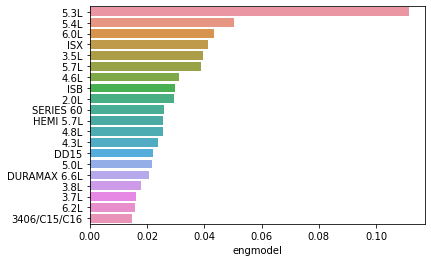

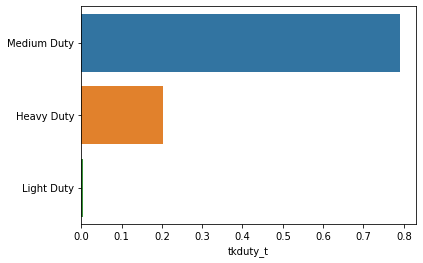

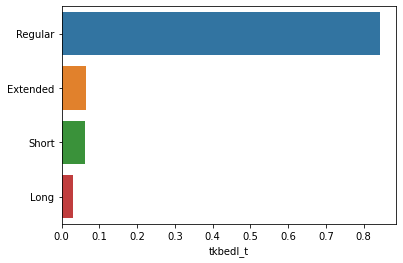

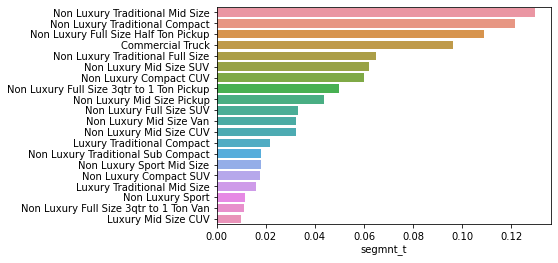

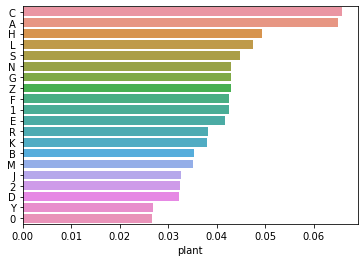

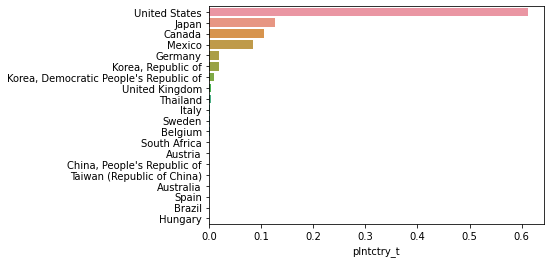

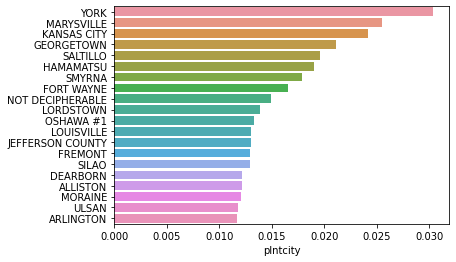

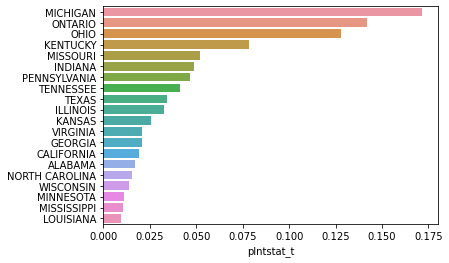

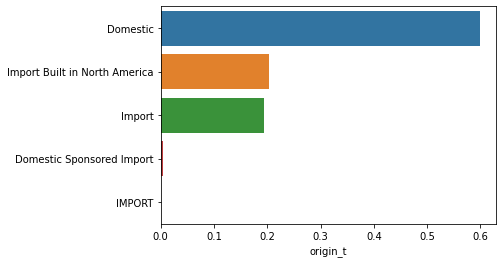

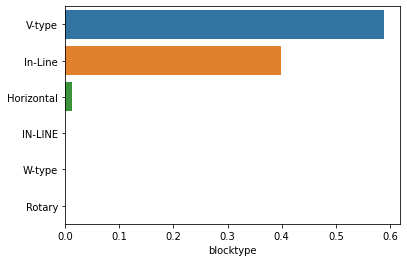

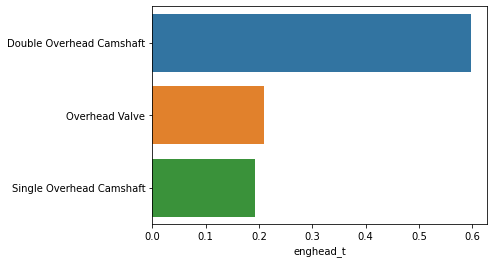

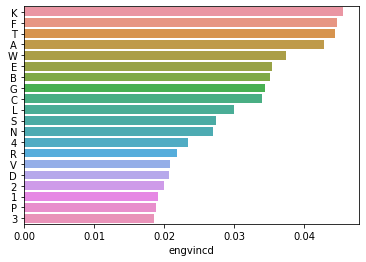

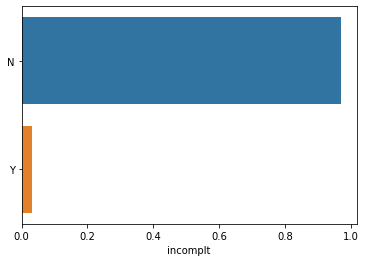

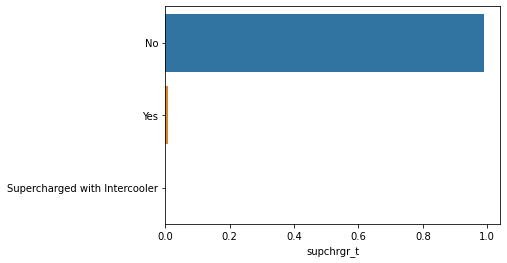

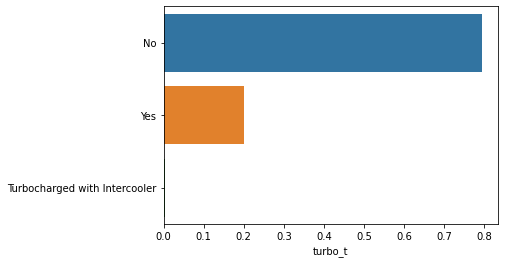

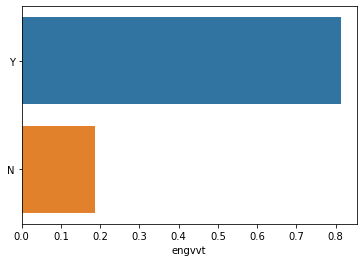

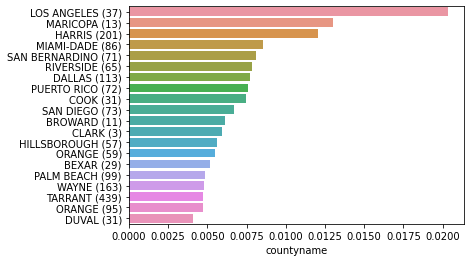

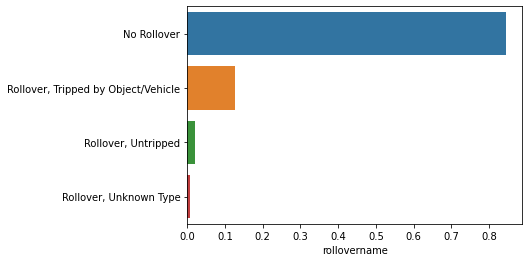

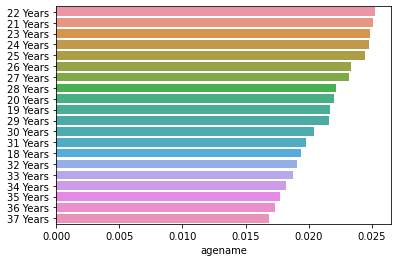

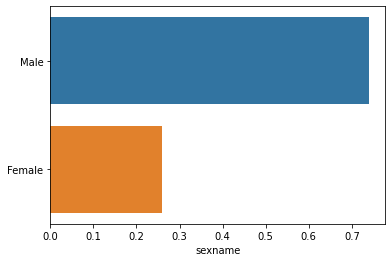

In [31]:
# Bar plots of categorical features

for feature in data.dtypes[data.dtypes == 'object'].index:
    sns.barplot(x=data[feature].value_counts(normalize=True, sort=True)[0:20], y=data[feature].value_counts(normalize=True, sort=True)[0:20].index, orient='h', order=data[feature].value_counts(normalize=True, sort=True)[0:20].index)
    plt.show()

In [32]:
# Summary of numeric features
data[numeric].describe().round(1)

,per_no,vinyear,doors,wheels,drivwhls,displci,whlbsh,whlblg,shipweight,msrp,dispclmt,vlvclndr,vlvtotal
count,304126.0,291256.0,236809.0,198747.0,198747.0,260606.0,235842.0,235841.0,260350.0,264058.0,253161.0,291256.0,291256.0
mean,1.0,2006.2,3.6,4.2,2.8,264.6,116.1,120.0,3480.7,23897.2,4.1,1.8,9.8
std,0.0,6.9,0.8,0.6,1.0,183.2,15.8,26.0,1409.5,10816.8,2.7,1.9,10.2
min,1.0,1981.0,2.0,2.0,2.0,39.0,73.5,73.5,83.0,498.0,0.7,0.0,0.0
25%,1.0,2002.0,4.0,4.0,2.0,146.0,105.9,105.9,2905.0,17155.8,2.4,0.0,0.0
50%,1.0,2006.0,4.0,4.0,2.0,214.0,110.5,110.5,3457.0,22500.0,3.5,2.0,12.0
75%,1.0,2012.0,4.0,4.0,4.0,323.0,120.5,123.9,4310.0,28995.0,5.0,4.0,16.0
max,8.0,2020.0,5.0,14.0,8.0,1099.0,254.0,960.0,14795.0,441600.0,16.1,16.0,48.0


No Rollover                            0.845406
Rollover, Tripped by Object/Vehicle    0.126359
Rollover, Untripped                    0.020561
Rollover, Unknown Type                 0.007674
Name: rollovername, dtype: float64


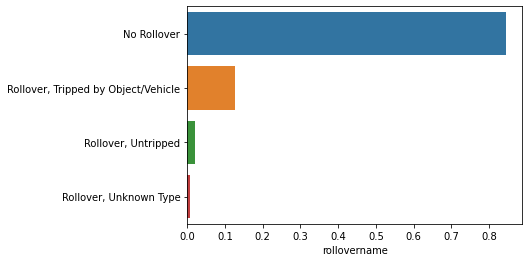

In [33]:
# Target Veriable Bar Plot & their value_counts()
print(data[target_name].value_counts(normalize=True))
sns.barplot(x=data[target_name].value_counts(normalize=True), y=data[target_name].value_counts(normalize=True).index, orient='h')
plt.show()

## ***Part 3 - Data Cleaning and Feature Engineering***

### ***Handling with Missing Values: Dropping and/or Imputation***

In [34]:
# Dropping some unnecassary columns
data.drop(["countyname", "engvincd", "vintrim_t", "vinmodel_t", "plant", "plntcity", "plntstat_t", "engmodel"], axis=1, inplace=True)
print("Data DataFrame Shape After Drop:", data.shape)

# Rearranging the categorical list
categorical = ['statename', 'vehtype_t', 'vinmake_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plntctry_t', 'origin_t', 'blocktype', 'enghead_t', 'incomplt', 'supchrgr_t', 'turbo_t', 'engvvt', 'agename', 'sexname'] # names of columns having categorical values
numeric = ['per_no', 'vinyear', 'doors', 'wheels', 'drivwhls', 'displci', 'whlbsh', 'whlblg', 'shipweight', 'msrp', 'dispclmt', 'vlvclndr', 'vlvtotal'] # names of columns having numerical values
target_name = 'rollovername' # set the column name of target variable (it is named 'rollovername' in FARS datasets)

features = categorical + numeric

Data DataFrame Shape After Drop: (304126, 53)


In [35]:
# Dealing with categorical & numerical missing values 
# Replacing them by their mean & mode

mean_value_list = ['per_no', 'doors', 'wheels', 'drivwhls', 'displci', 'whlbsh', 'whlblg', 'shipweight', 'msrp', 'dispclmt', 'vlvclndr', 'vlvtotal']
mode_value_list = ['vinyear', 'statename', 'vehtype_t', 'vinmake_t', 'bodystyl_t', 'mfg_t', 'cylndrs', 'fuel_t', 'fuelinj_t', 'carbtype_t', 'gvwrange_t', 'tiresz_f_t', 'rearsize_t', 'tonrating', 'drivetyp_t', 'abs_t', 'security_t', 'drl_t', 'rstrnt_t', 'tkcab_t', 'tkaxlef_t', 'tkaxler_t', 'tkbrak_t', 'engmfg_t', 'tkduty_t', 'tkbedl_t', 'segmnt_t', 'plntctry_t', 'origin_t', 'blocktype', 'enghead_t', 'incomplt', 'supchrgr_t', 'turbo_t', 'engvvt', 'agename', 'sexname']

for mean_columns in data[mean_value_list]:
    data[mean_columns].fillna(data[mean_columns].mean(), inplace=True)

for mode_coloumns in data[mode_value_list]:
    data[mode_coloumns].fillna(data[mode_coloumns].value_counts().idxmax(), inplace=True)

In [36]:
# Showing the null values are reset after imputation
print("\033[1m" + "NUMERICAL" + "\033[0m")
print(data[numeric].isnull().sum())

print("\033[1m" + "CATEGORICAL" + "\033[0m")
print(data[categorical].isnull().sum())

NUMERICAL
per_no        0
vinyear       0
doors         0
wheels        0
drivwhls      0
displci       0
whlbsh        0
whlblg        0
shipweight    0
msrp          0
dispclmt      0
vlvclndr      0
vlvtotal      0
dtype: int64
CATEGORICAL
statename     0
vehtype_t     0
vinmake_t     0
bodystyl_t    0
mfg_t         0
cylndrs       0
fuel_t        0
fuelinj_t     0
carbtype_t    0
gvwrange_t    0
tiresz_f_t    0
rearsize_t    0
tonrating     0
drivetyp_t    0
abs_t         0
security_t    0
drl_t         0
rstrnt_t      0
tkcab_t       0
tkaxlef_t     0
tkaxler_t     0
tkbrak_t      0
engmfg_t      0
tkduty_t      0
tkbedl_t      0
segmnt_t      0
plntctry_t    0
origin_t      0
blocktype     0
enghead_t     0
incomplt      0
supchrgr_t    0
turbo_t       0
engvvt        0
agename       0
sexname       0
dtype: int64


### ***Reducing cardinality of categorical features***

In [37]:
# Applying the Reducing Cardinality

data.vehtype_t.replace(['Truck', 'Commercial Trailer'], 'Truck', inplace=True)
data.carbtype_t.replace(['Fuel Injection', 'FUEL INJECTION'], 'Fuel Injection', inplace=True)
data.abs_t.replace(['All Wheel Std', 'ALL WHEEL STD'], 'All Wheel Std', inplace=True)
data.drl_t.replace(['Standard', 'STANDARD'], 'Standard', inplace=True)
data.origin_t.replace(['Import', 'IMPORT', 'Import Built in North America', 'Domestic Sponsored Import'], 'Import', inplace=True)
data.turbo_t.replace(['Yes', 'Turbocharged with Intercooler'], 'Yes', inplace=True)
data.supchrgr_t.replace(['Yes', 'Supercharged with Intercooler'], 'Yes', inplace=True)
data.rollovername.replace(['Rollover, Tripped by Object/Vehicle', 'Rollover, Untripped', 'Rollover, Unknown Type'], 'Rollover', inplace=True)
data.blocktype.replace(['In-Line', 'IN-LINE'], 'In-Line', inplace=True)
data.tkbrak_t.replace(['AIR/HYD', 'HYD.-VAC.', 'HYD.-AIR'], 'HYDRAULIC', inplace=True)

data.fuel_t.replace(['GAS', 'Gas', 'Compressed Natural Gas'], 'Gas', inplace=True)
data.fuel_t.replace(['Electric and Gas Hybrid', 'Electric and Diesel Hybrid'], 'Hybrid', inplace=True)
data.drivetyp_t.replace(['Rear Wheel Drive', 'Rear Wheel Drive w/4x4'], 'Rear Wheel Drive', inplace=True)
data.drivetyp_t.replace(['Front Wheel Drive', 'Front Wheel Drive w/4x4', 'FRONT WHEEL DRIVE'], 'Front Wheel Drive', inplace=True)

data.bodystyl_t.replace(['Van Passenger', 'Van Cargo', 'Step Van', 'Van', 'Cutaway', 'VAN CARGO', 'VAN PASSENGER', 'STEP VAN', 'VAN CAMPER', 'CUTAWAY'], 'VAN', inplace=True)
data.bodystyl_t.replace(['Bus Non School', 'Bus School', 'BUS SCHOOL', 'BUS NON SCHOOL'], 'BUS', inplace=True)
data.bodystyl_t.replace(['Pickup', 'Tractor Truck', 'Straight Truck', 'Sport Utility Truck', 'Incomplete Pickup', 'Motor Home', 'PICKUP', 'STRAIGHT TRUCK', 'TRACTOR TRUCK', 'SPORT UTILITY TRUCK', 'INCOMPLETE PICKUP', 'MOTOR HOME', 'FIRE TRUCK', 'COMMERCIAL CHASSIS', 'FLATBED', 'GRAIN', 'LOGGING'], 'TRUCK', inplace=True)
data.bodystyl_t.replace(['Sport Utility Vehicle', 'Sport', 'Competition', 'Touring', 'TOURING', 'SPORT UTILITY VEHICLE', 'SPORT', 'COMPETITION'], 'SPORT', inplace=True)
data.bodystyl_t.replace(['Sedan', 'Hatchback', 'Coupe', 'Convertible', 'Traditional', 'Wagon', 'Limousine', 'SEDAN', 'HATCHBACK', 'CONVERTIBLE', 'WAGON', 'COUPE', 'TRADITIONAL', 'LIMOUSINE', 'HEARSE'], 'STANDARD', inplace=True)
data.bodystyl_t.replace(['Cruiser', 'CRUISER'], 'CRUISER', inplace=True)

data.cylndrs.replace(['1', '1.0'], '1', inplace=True)
data.cylndrs.replace(['2', '2.0'], '2', inplace=True)
data.cylndrs.replace(['3', '3.0'], '3', inplace=True)
data.cylndrs.replace(['4', '4.0'], '4', inplace=True)
data.cylndrs.replace(['5', '5.0'], '5', inplace=True)
data.cylndrs.replace(['6', '6.0'], '6', inplace=True)
data.cylndrs.replace(['8', '8.0'], '8', inplace=True)
data.cylndrs.replace(['10', '10.0'], '10', inplace=True)

data.segmnt_t.replace([value for value in pd.unique(data["segmnt_t"].values) if value.startswith('N')], "Non Luxury", inplace=True)
data.segmnt_t.replace([value for value in pd.unique(data["segmnt_t"].values) if value.startswith('L')], "Luxury", inplace=True)

data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('12')], '12', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('13')], '13', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('14')], '14', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('15')], '15', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('16')], '16', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('17')], '17', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('18')], '18', inplace=True)   
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('19')], '19', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('20')], '20', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('21')], '21', inplace=True)
data.tiresz_f_t.replace([value for value in pd.unique(data['tiresz_f_t'].values) if value.startswith('22')], '22', inplace=True)

data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('14')], '14', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('15')], '15', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('16')], '16', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('17')], '17', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('18')], '18', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('19')], '19', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('20')], '20', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('21')], '21', inplace=True)
data.rearsize_t.replace([value for value in pd.unique(data['rearsize_t'].values) if value.startswith('22')], '22', inplace=True)

data.agename.replace([value for value in pd.unique(data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(0,20)], '0-20 Years', inplace=True)
data.agename.replace([value for value in pd.unique(data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(20,40)], '20-40 Years', inplace=True)
data.agename.replace([value for value in pd.unique(data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(40,60)], '40-60 Years', inplace=True)
data.agename.replace([value for value in pd.unique(data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(60,80)], '60-80 Years', inplace=True)
data.agename.replace([value for value in pd.unique(data['agename'].values) if value.split()[0].isnumeric() and int(value.split()[0]) in range(80,100)], '80-100 Years', inplace=True)

In [38]:
# mapFunc in order to reduce the cardinality of the Categorical data value by 5%
def mapFunc(categoricalData, data):
    map_ = dict()
    for indx in range(len(data[categoricalData].value_counts().index)):
        if data[categoricalData].value_counts()[indx]/data.shape[0] < 0.05:
            map_[data[categoricalData].value_counts().index[indx]] = 'Other'
        else:
            map_[data[categoricalData].value_counts().index[indx]] = data[categoricalData].value_counts().index[indx]
    return map_

In [39]:
# Calling the mapFunc Function
for categoricalData in categorical:
    data[categoricalData] = data[categoricalData].map(mapFunc(categoricalData, data))

In [40]:
# Value counts of categorical features after applying the Reducing Cardinality 
for categoric in data.dtypes[data.dtypes == 'object'].index:
    print("\033[1m" + categoric.upper() + "\033[0m")
    print(data[categoric].value_counts().to_dict())
    print()

STATENAME
{'Other': 217460, 'Texas': 30626, 'California': 29936, 'Florida': 26104}

VEHTYPE_T
{'Truck': 163287, 'Passenger Car': 110660, 'Motorcycle': 30179}

VINMAKE_T
{'Other': 146048, 'FORD': 55020, 'CHEVROLET': 40521, 'TOYOTA': 24781, 'HONDA': 21487, 'DODGE': 16269}

BODYSTYL_T
{'STANDARD': 124520, 'TRUCK': 74832, 'SPORT': 73127, 'Other': 31647}

MFG_T
{'Other': 120500, 'General Motors': 74797, 'Ford': 43442, 'Toyota': 23702, 'Chrysler Group LLC': 21479, 'Honda': 20206}

CYLNDRS
{'6': 125834, '4': 94664, '8': 60067, '2': 17414, 'Other': 6147}

FUEL_T
{'Gas': 249334, 'Diesel': 33451, 'Flexible': 18551, 'Other': 2790}

FUELINJ_T
{'Sequential': 260451, 'Direct': 27274, 'Other': 16401}

CARBTYPE_T
{'Fuel Injection': 302941, 'Other': 1185}

GVWRANGE_T
{'0 - 6,000#': 216866, '6,001 - 10,000#': 58386, '33,000# +': 19890, 'Other': 8984}

TIRESZ_F_T
{'16': 182884, '17': 46265, '15': 40561, 'Other': 18389, '18': 16027}

REARSIZE_T
{'16': 246877, '17': 30607, 'Other': 26642}

TONRATING
{'B': 

In [41]:
# Convert the categorical Target Name to numeric value
data['rollovername'].replace('Rollover', 1, inplace=True)
data['rollovername'].replace('No Rollover', 0, inplace=True)

## ***Part 4 - Data Splitting and Transformation***

In [43]:
# Split the data to independent variables(y) and dependent variable(x)

X = data[features]
Y = data[target_name]

# We split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# We should look the X train & Y train data shape because it should be equal
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print()
print("X test shape: ", X_test.shape)
print("Y test shape: ", Y_test.shape)

X train shape:  (212888, 49)
Y train shape:  (212888,)

X test shape:  (91238, 49)
Y test shape:  (91238,)


In [44]:
# Use StandartScaller and transform each numeric feature accordingly. 
scaler = StandardScaler()

X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [45]:
# Applying one-hot encoding in order to convert the categorical data to numeric data
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies = pd.get_dummies(X_test)

print("X train shape after one-hot encoding: ", X_train_dummies.shape)
print("X test shape after one-hot encoding: ", X_test_dummies.shape)

X train shape after one-hot encoding:  (212888, 135)
X test shape after one-hot encoding:  (91238, 135)


## ***Part 5 - Feature Selection***

In [46]:
# Find the best features for the given X training set & convert the best 30 features to DataFrame
# K -> the number of the important features
# F_classif -> evaluation function

from sklearn.feature_selection import SelectKBest, f_classif

bestFit = SelectKBest(f_classif, k=10).fit(X_train_dummies, Y_train)
X_bestFit = SelectKBest(f_classif, k=10).fit_transform(X_train_dummies, Y_train)

scoresDf = pd.concat([pd.DataFrame(X_train_dummies.columns), pd.DataFrame(bestFit.scores_)], axis=1)
scoresDf.columns=["X Train Dummies Feature", "Score"]
scoresDf.nlargest(30, "Score")

,X Train Dummies Feature,Score
66,drivetyp_t_Rear Wheel Drive,4278.583949
65,drivetyp_t_Front Wheel Drive,4190.659246
1,vinyear,3487.736597
8,shipweight,3318.224377
17,vehtype_t_Motorcycle,2831.945040
19,vehtype_t_Truck,2805.967158
36,cylndrs_2,1787.893633
75,drl_t_Not Available,1685.317703
39,cylndrs_8,1579.272516
78,drl_t_Standard,1531.308592


In [47]:
# Create & Append the best 30 features to the list
best_column_list = []
for columns in scoresDf.nlargest(30, "Score").values:
    best_column_list.append(columns[0])

In [48]:
# Fetching the best 30 features
X_train_dummies_new = X_train_dummies[best_column_list]
X_test_dummies_new = X_test_dummies[best_column_list]

In [49]:
# Showing the first 5 row for new x_train DataFrame
X_train_dummies_new.head()

,drivetyp_t_Rear Wheel Drive,drivetyp_t_Front Wheel Drive,vinyear,shipweight,vehtype_t_Motorcycle,vehtype_t_Truck,cylndrs_2,drl_t_Not Available,cylndrs_8,drl_t_Standard,rstrnt_t_Other,"gvwrange_t_6,001 - 10,000#",rstrnt_t_Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,bodystyl_t_TRUCK,cylndrs_4,security_t_Pass Key,enghead_t_Double Overhead Camshaft,origin_t_Import,origin_t_Domestic,rearsize_t_16,tkcab_t_Extended Cab,bodystyl_t_STANDARD,doors,drivwhls,abs_t_Other,vinmake_t_CHEVROLET,vinmake_t_Other,tkcab_t_Sport Utility,bodystyl_t_Other,vlvclndr
83341,0,1,0.107224,-0.600054,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0,1,0.543875,-0.000732,0,0,1,1,0,-0.999028
138707,1,0,-0.936085,0.280353,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0.543875,-1.029146,1,0,1,1,0,1.199342
172148,0,1,-0.190864,0.083259,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0.543875,-0.000732,0,0,1,1,0,-0.999028
11954,1,0,-0.787041,0.553371,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,1,1,0,0.543875,-1.029146,0,0,0,0,0,0.100157
280873,1,0,-0.190864,-0.001302,0,1,0,0,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0.000411,1.485175,0,0,1,0,0,-0.999028


In [50]:
# Showing the first 5 row for new x_test DataFrame
X_test_dummies_new.head()

,drivetyp_t_Rear Wheel Drive,drivetyp_t_Front Wheel Drive,vinyear,shipweight,vehtype_t_Motorcycle,vehtype_t_Truck,cylndrs_2,drl_t_Not Available,cylndrs_8,drl_t_Standard,rstrnt_t_Other,"gvwrange_t_6,001 - 10,000#",rstrnt_t_Du Frnt/Sd/Hd Air Bgs/Rr Hd Ar Bgs/Act Belts,bodystyl_t_TRUCK,cylndrs_4,security_t_Pass Key,enghead_t_Double Overhead Camshaft,origin_t_Import,origin_t_Domestic,rearsize_t_16,tkcab_t_Extended Cab,bodystyl_t_STANDARD,doors,drivwhls,abs_t_Other,vinmake_t_CHEVROLET,vinmake_t_Other,tkcab_t_Sport Utility,bodystyl_t_Other,vlvclndr
35578,0,1,0.703401,0.840194,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0.543875,-1.029146,0,0,0,1,0,1.199342
176433,0,1,-0.041820,-0.251112,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0.543875,-1.029146,0,1,0,0,1,-0.999028
50399,0,1,0.852445,-0.224270,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0.543875,-1.029146,0,0,0,1,0,1.199342
228921,0,1,-0.190864,-2.502745,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0.000411,-0.000732,0,0,0,1,0,-0.999028
276062,0,0,-0.041820,0.225903,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0.543875,1.485175,0,1,0,1,0,-0.999028


## ***Part 6 - Training & Performance Evaluation***

In [51]:
# Initialize the Naive Bayes model implementation
# Fit the training data to the model (training)
naive_bayes = GaussianNB()
naive_bayes.fit(X_train_dummies_new, Y_train)

GaussianNB()

In [52]:
# Predict the value by the x_test
naive_bayes.predict(X_test_dummies_new)

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [53]:
# Predict the probabilty of the value by the x_test
naive_bayes.predict_proba(X_test_dummies_new)

array([[0.97185164, 0.02814836],
       [0.97520716, 0.02479284],
       [0.99877102, 0.00122898],
       ...,
       [0.95167905, 0.04832095],
       [0.09274751, 0.90725249],
       [0.07767893, 0.92232107]])

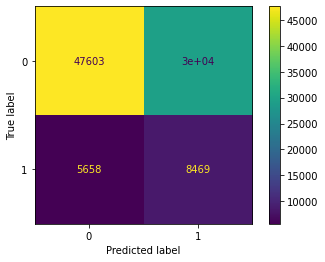

In [54]:
# Confusion Matrix Visualization in order to see precission, recall & f1 score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, naive_bayes.predict(X_test_dummies_new))).plot()

In [55]:
# Classification_report in order to see the accurarcy & avarage value
print(classification_report(Y_test, naive_bayes.predict(X_test_dummies_new)))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73     77111
           1       0.22      0.60      0.33     14127

    accuracy                           0.61     91238
   macro avg       0.56      0.61      0.53     91238
weighted avg       0.79      0.61      0.67     91238



In [56]:
# Convert Classification Report to Dictionary in order to use the plotting the performance of the model
naive_bayes_classification_report_dict = classification_report(Y_test, naive_bayes.predict(X_test_dummies_new), output_dict=True)

In [57]:
# Initialize the Logistic Regression model implementation
# Fit the training data to the model (training)
# C is the regularization parameter to avoid the overfitting

logisticRegModel = LogisticRegression(C=1, class_weight='balanced')
logisticRegModel.fit(X_train_dummies_new, Y_train)

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1, class_weight='balanced')

In [58]:
# Predict the value by the x_test
logisticRegModel.predict(X_test_dummies_new)

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [59]:
# Predict the probabilty of the value by the x_test
logisticRegModelProba = logisticRegModel.predict_proba(X_test_dummies_new)

In [60]:
# Printing the score of the model
print("Logistic Regression Model Score: ", logisticRegModel.score(X_test_dummies_new, Y_test))

Logistic Regression Model Score:  0.6027313180911462


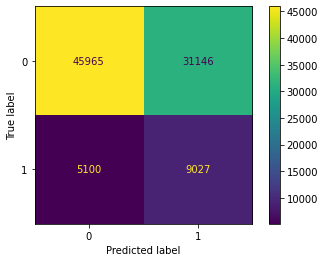

In [61]:
# Confusion Matrix Visualization in order to see precission, recall & f1 score
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, logisticRegModel.predict(X_test_dummies_new))).plot()

In [62]:
# Classification_report in order to see the accurarcy & avarage value
print(classification_report(Y_test, logisticRegModel.predict(X_test_dummies_new)))

              precision    recall  f1-score   support

           0       0.90      0.60      0.72     77111
           1       0.22      0.64      0.33     14127

    accuracy                           0.60     91238
   macro avg       0.56      0.62      0.52     91238
weighted avg       0.80      0.60      0.66     91238



In [63]:
# Convert Classification Report to Dictionary in order to use the plotting the performance of the model
logistic_classification_report_dict = classification_report(Y_test, logisticRegModel.predict(X_test_dummies_new), output_dict=True)

In [64]:
# Initialize the Support Vector Machine model implementation
# Fit the training data to the model (training)

supportVectorMach = SVC(kernel="linear", C=0.1, random_state=0)
supportVectorMach.fit(X_train_dummies_new, Y_train)

SVC(C=0.1, kernel='linear', random_state=0)

In [65]:
# Predict the value by the x_test
supportVectorMach.predict(X_test_dummies_new)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

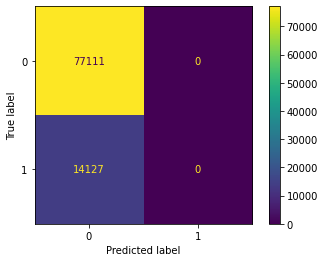

In [66]:
# Confusion Matrix Visualization in order to see precission, recall & f1 score
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, supportVectorMach.predict(X_test_dummies_new))).plot()

In [67]:
# Classification_report in order to see the accurarcy & avarage value
print(classification_report(Y_test, supportVectorMach.predict(X_test_dummies_new)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     77111
           1       0.00      0.00      0.00     14127

    accuracy                           0.85     91238
   macro avg       0.42      0.50      0.46     91238
weighted avg       0.71      0.85      0.77     91238



c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [68]:
# Convert Classification Report to Dictionary in order to use the plotting the performance of the model
spv_classification_report_dict = classification_report(Y_test, supportVectorMach.predict(X_test_dummies_new), output_dict=True)

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [69]:
# Initialize the Random Forest model implementation
# Fit the training data to the model (training)

randomForest = RandomForestClassifier(criterion="entropy", n_estimators=100, max_depth=4, random_state=0, class_weight="balanced")
randomForest.fit(X_train_dummies_new, Y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, random_state=0)

In [70]:
# Printing the score of the model
print("Random Forest Model Score: ", randomForest.score(X_test_dummies_new, Y_test))

Random Forest Model Score:  0.6498169622306496


In [71]:
# Predict the value by the x_test
randomForest.predict(X_test_dummies_new)

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [72]:
# Predict the probabilty of the value by the x_test
randomForest.predict_proba(X_test_dummies_new)

array([[0.62217291, 0.37782709],
       [0.5139212 , 0.4860788 ],
       [0.63058518, 0.36941482],
       ...,
       [0.52197624, 0.47802376],
       [0.3614024 , 0.6385976 ],
       [0.41547579, 0.58452421]])

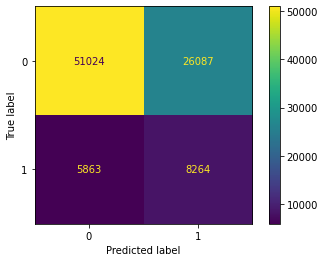

In [73]:
# Confusion Matrix Visualization in order to see precission, recall & f1 score
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, randomForest.predict(X_test_dummies_new))).plot()

In [74]:
# Classification_report in order to see the accurarcy & avarage value
print(classification_report(Y_test, randomForest.predict(X_test_dummies_new)))

              precision    recall  f1-score   support

           0       0.90      0.66      0.76     77111
           1       0.24      0.58      0.34     14127

    accuracy                           0.65     91238
   macro avg       0.57      0.62      0.55     91238
weighted avg       0.80      0.65      0.70     91238



In [75]:
# Convert Classification Report to Dictionary in order to use the plotting the performance of the model
random_forest_classification_report_dict = classification_report(Y_test, randomForest.predict(X_test_dummies_new), output_dict=True)

### ***Plotting training and testing performance of all models with a bar chart.***

<AxesSubplot:>

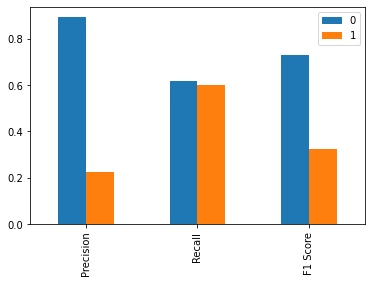

In [76]:
# Naive Bayes Bar Chart Visulization

X = ['Precision', 'Recall', 'F1 Score']
Y = [naive_bayes_classification_report_dict['0']['precision'], naive_bayes_classification_report_dict['0']['recall'], naive_bayes_classification_report_dict['0']['f1-score']]
Z = [naive_bayes_classification_report_dict['1']['precision'], naive_bayes_classification_report_dict['1']['recall'], naive_bayes_classification_report_dict['1']['f1-score']]

df = pd.DataFrame(np.c_[Y,Z], index=X)
df.plot.bar()

<AxesSubplot:>

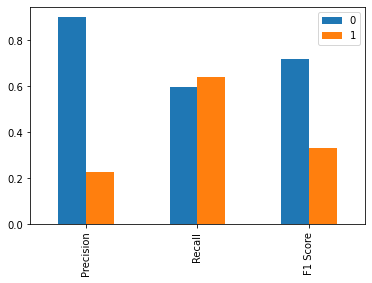

In [77]:
# logistic Regrassion Bar Chart Visulization

X = ['Precision', 'Recall', 'F1 Score']
Y = [logistic_classification_report_dict['0']['precision'], logistic_classification_report_dict['0']['recall'], logistic_classification_report_dict['0']['f1-score']]
Z = [logistic_classification_report_dict['1']['precision'], logistic_classification_report_dict['1']['recall'], logistic_classification_report_dict['1']['f1-score']]

df = pd.DataFrame(np.c_[Y,Z], index=X)
df.plot.bar()

<AxesSubplot:>

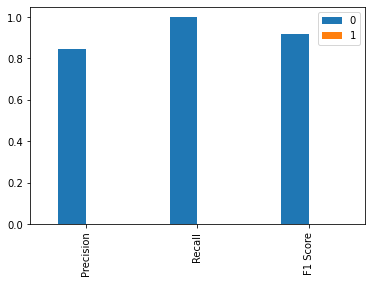

In [78]:
# Support Vector Machines Bar Chart Visulization

X = ['Precision', 'Recall', 'F1 Score']
Y = [spv_classification_report_dict['0']['precision'], spv_classification_report_dict['0']['recall'], spv_classification_report_dict['0']['f1-score']]
Z = [spv_classification_report_dict['1']['precision'], spv_classification_report_dict['1']['recall'], spv_classification_report_dict['1']['f1-score']]

df = pd.DataFrame(np.c_[Y,Z], index=X)
df.plot.bar()

<AxesSubplot:>

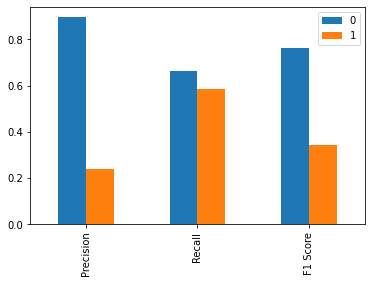

In [79]:
# Random Forest Bar Chart Visulization

X = ['Precision', 'Recall', 'F1 Score']
Y = [random_forest_classification_report_dict['0']['precision'], random_forest_classification_report_dict['0']['recall'], random_forest_classification_report_dict['0']['f1-score']]
Z = [random_forest_classification_report_dict['1']['precision'], random_forest_classification_report_dict['1']['recall'], random_forest_classification_report_dict['1']['f1-score']]

df = pd.DataFrame(np.c_[Y,Z], index=X)
df.plot.bar()